## SVHN Prediction on random images

In [1]:
import os
import PIL.Image as Image
import matplotlib
import numpy as np
import tensorflow as tf
import random
import gzip
import matplotlib.pyplot as plt

%matplotlib inline

### Create graph and run model

In [2]:
labels = 11
channels = 1

def run_predict_model(batch_size, image_size, X_test):
    patch_size = 5
    channels1 = 16
    channels2 = 32
    channels3 = 64
    channels4 = 128
    
    shape = [batch_size, image_size, image_size, channels]
    graph = tf.Graph()
    
    with graph.as_default():
        tf_X_test = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, channels))
        
        W1 = tf.get_variable('W1', 
                            shape=[patch_size, patch_size, channels, channels1],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        W2 = tf.get_variable('W2', 
                            shape=[patch_size, patch_size, channels1, channels2],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        W3 = tf.get_variable('W3', 
                            shape=[patch_size, patch_size, channels2, channels3],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
        W4 = tf.get_variable('W4', 
                            shape=[patch_size, patch_size, channels3, channels4],
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())        
        
        b1 = tf.Variable(tf.constant(1.0, shape=[channels1]), name='b1')
        b2 = tf.Variable(tf.constant(1.0, shape=[channels2]), name='b2')
        b3 = tf.Variable(tf.constant(1.0, shape=[channels3]), name='b3')
        b4 = tf.Variable(tf.constant(1.0, shape=[channels4]), name='b4')
        
        Lw = tf.get_variable('Lw', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw1 = tf.get_variable('Sw1', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw2 = tf.get_variable('Sw2', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw3 = tf.get_variable('Sw3', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw4 = tf.get_variable('Sw4', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
        Sw5 = tf.get_variable('Sw5', 
                            shape=[channels4, labels],
                            initializer=tf.contrib.layers.xavier_initializer())
                           
        Lb = tf.Variable(tf.constant(1.0, shape=[labels]), name='Lb')
        Sb1 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb1')
        Sb2 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb2') 
        Sb3 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb3')
        Sb4 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb4')
        Sb5 = tf.Variable(tf.constant(1.0, shape=[labels]), name='Sb5')
        
        def createModel(data, keep_prob, shape):
            h_conv1 = tf.nn.relu(tf.nn.conv2d(data, W1, [1, 1, 1, 1], 'VALID', name='h_conv1') + b1)
            lrn = tf.nn.local_response_normalization(h_conv1)
            h_drop = tf.nn.dropout(lrn, keep_prob)
            
            h_pool1 = tf.nn.max_pool(h_drop, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='h_pool1')
            h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W2, [1, 1, 1, 1], 'VALID', name='h_conv2') + b2)
            lrn = tf.nn.local_response_normalization(h_conv2)
            h_drop = tf.nn.dropout(lrn, keep_prob)
            
            h_pool2 = tf.nn.max_pool(h_drop, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='h_pool2')
            h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, W3, [1, 1, 1, 1], 'VALID', name='h_conv3') + b3)
            h_drop = tf.nn.dropout(h_conv3, keep_prob)

            h_pool3 = tf.nn.max_pool(h_drop, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='h_pool3')
            h_conv4 = tf.nn.relu(tf.nn.conv2d(h_pool3, W4, [1, 1, 1, 1], 'SAME', name='h_conv4') + b4)
            h_drop = tf.nn.dropout(h_conv4, keep_prob)
            
            h_drop_shape = h_drop.get_shape().as_list()
            h_drop = tf.reshape(h_drop, [h_drop_shape[0], h_drop_shape[1] * h_drop_shape[2] * h_drop_shape[3]])
            
            L = tf.matmul(h_drop, Lw) + Lb
            S1 = tf.matmul(h_drop, Sw1) + Sb1
            S2 = tf.matmul(h_drop, Sw2) + Sb2
            S3 = tf.matmul(h_drop, Sw3) + Sb3
            S4 = tf.matmul(h_drop, Sw4) + Sb4
            S5 = tf.matmul(h_drop, Sw5) + Sb5
            
            return [L, S1, S2, S3, S4, S5]
        
        [L, S1, S2, S3, S4, S5] = createModel(tf_X_test, 1.0, shape)

        test_prediction = tf.transpose(tf.argmax(tf.pack([tf.nn.softmax(L), tf.nn.softmax(S1), tf.nn.softmax(S2),
                                    tf.nn.softmax(S3), tf.nn.softmax(S4), tf.nn.softmax(S5)]), 2))
        
        save_model = tf.train.Saver()
        
        with tf.Session(graph=graph) as sess:
            save_model.restore(sess, './data/256_0.9_0.05_50000.ckpt')
            y_test_prediction = sess.run(test_prediction, feed_dict={tf_X_test:X_test[:batch_size, :, :, :], })
    return y_test_prediction

### Run model on random images and display predicted number

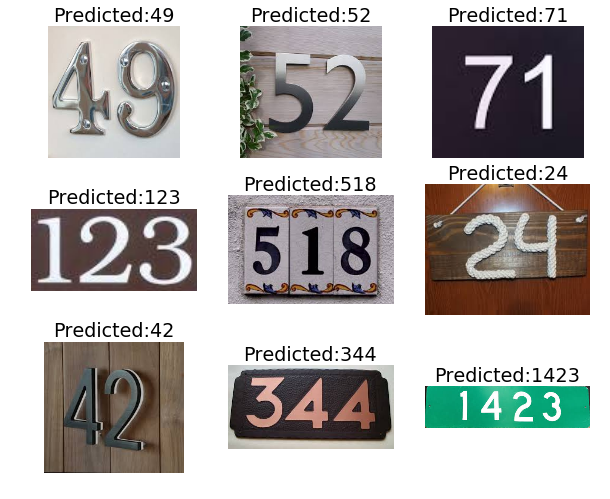

In [3]:
image_size = 32
num_images = 9
X_test = np.ndarray([num_images, image_size, image_size], dtype='float32')

for i in range(num_images):
    test_file = 'test_img' + str(i) + '.png'
    test_image = Image.open(test_file).convert('L').resize([image_size, image_size], Image.ANTIALIAS)
    test_image = np.array(test_image, dtype='float32')
    X_test[i, :, :] = test_image[:, :]
    
X_test = X_test.reshape((num_images, image_size, image_size, 1))
y_predicted = run_predict_model(num_images, image_size, X_test)

fig = plt.figure(figsize=(10, 8))
matplotlib.rcParams.update({'font.size': 16})

for i in range(num_images):
    plt.subplot(330 + i + 1)
    test_file = 'test_img' + str(i) + '.png'
    test_image = Image.open(test_file)
    plt.imshow(test_image)
    predicted_str = 'Predicted:' + ''.join(map(str, y_predicted[i][1:y_predicted[i][0]+1]))
    plt.title(predicted_str)
    plt.axis('off')
plt.show()